In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import scipy
from scipy import optimize
from scipy.optimize import leastsq
from io import StringIO
from scipy.signal import savgol_filter
from datetime import datetime

now = datetime.now()
d_string = now.strftime("%d.%m.%Y")

%run Functions.ipynb



<Figure size 432x288 with 0 Axes>

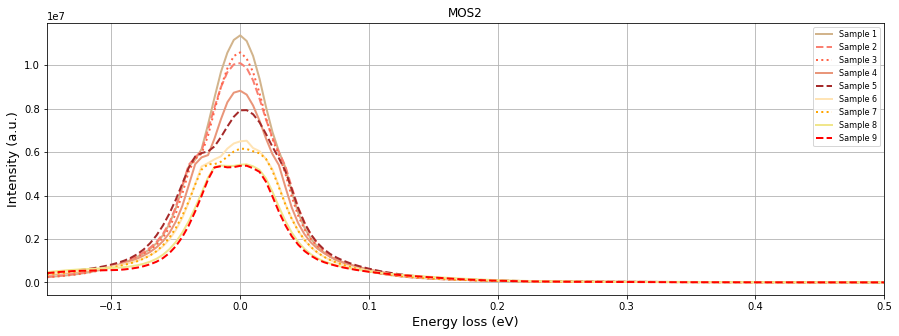

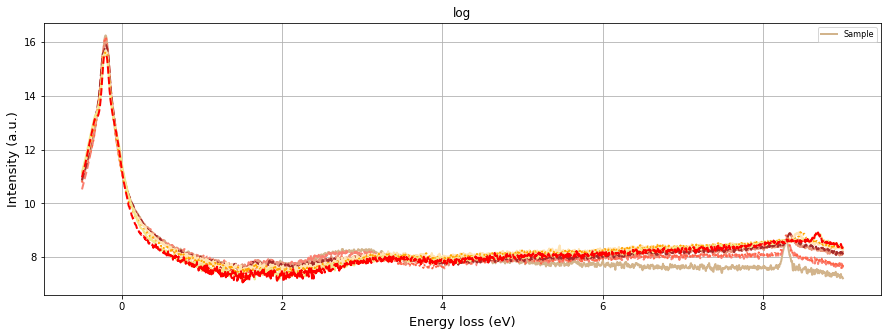

In [2]:
%run EELS-ZLP-May.py

In [3]:


ZLP_data = pd.DataFrame({"x1": x1 + 0.2025, "y1": y1, "log(y1)": np.log(y1), "x2": x2+ 0.2025, "y2": y2, "log(y2)": log_y2, "x3": x3+ 0.2025, "y3": y3, "log(y3)": log_y3, "x4": x4+ 0.2025, "y4": y4, "log(y4)": log_y4, "x5": x5+ 0.2025, "y5": y5, "log(y5)": log_y5, "x6": x6+ 0.2025, "y6": y6, "log(y6)": log_y6, "x7": x7+ 0.2025, "y7": y7, "log(y7)": log_y7 })
ZLP_data.head()

,x1,y1,log(y1),x2,y2,log(y2),x3,y3,log(y3),x4,...,log(y4),x5,y5,log(y5),x6,y6,log(y6),x7,y7,log(y7)
0,-0.295,51009.4,10.839765,-0.295,37132.3,10.522242,-0.295,47761.9,10.773984,-0.295,...,10.877766,-0.295,52060.1,10.860154,-0.295,67786.8,11.124123,-0.295,69074.8,11.142945
1,-0.290,53958.4,10.895969,-0.290,39514.2,10.584415,-0.290,50650.3,10.832700,-0.290,...,10.928776,-0.290,55517.7,10.924457,-0.290,70441.6,11.162539,-0.290,72512.9,11.191520
2,-0.285,57218.7,10.954636,-0.285,41907.8,10.643227,-0.285,53527.7,10.887955,-0.285,...,10.969513,-0.285,58852.8,10.982795,-0.285,73634.1,11.206864,-0.285,76263.1,11.241944
3,-0.280,60768.2,11.014822,-0.280,44538.1,10.704100,-0.280,56778.1,10.946906,-0.280,...,11.020462,-0.280,61641.9,11.029097,-0.280,78020.7,11.264729,-0.280,79955.5,11.289226
4,-0.275,64236.4,11.070325,-0.275,47017.3,10.758271,-0.275,59842.0,10.999463,-0.275,...,11.075290,-0.275,64394.5,11.072784,-0.275,81393.1,11.307046,-0.275,83668.6,11.334619


## Load predictions and training data

- Load the data files of today
- Select the ones that are good, based on a minimum $\chi^2_{test}$
- Only keep the good ones to make predictions


In [239]:
path_1 = r'Data/Results/%(now)s/' % {"now": d_string} # use your path
round_no = r'x4'
path_data = r'_xyp1p2_*.csv'
path_chi = r'_chi_*.csv' 
path_pred = path_4 = r'_extrapolation_*'

all_files = glob.glob(path_1 + round_no + path_data)
li = []
for filename in all_files:
    df = pd.read_csv(filename, delimiter=",", skiprows=0, header=None, usecols=[0,1,2], names=['x', 'y', 'pred'])
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)


In [240]:
# Put all data in a dataframe

training_data = pd.DataFrame()
training_data['x'] = frame.iloc[:,0]
training_data['y'] = frame.iloc[:,1]
training_data['prediction'] = frame.iloc[:,2]

training_data.head()

,x,y,prediction
0,1.381897,0.852917,1.101511
1,-0.060000,13.936221,14.445231
2,0.275000,10.515921,10.358805
3,0.050000,14.218184,14.551702
4,0.105000,13.100940,13.079380


In [241]:
all_files_chi = glob.glob(path_1 + round_no + path_chi)

all_files_chi_sort = np.sort(all_files_chi)
chi2_array = []
chi2_index = []

for filename in all_files_chi_sort:
    df = pd.read_csv(filename, delimiter=",", skiprows=0, header=None, usecols=[0,1])
    best_try = np.argmin(df[1])
    chi2_array.append(df.iloc[best_try,1])
    chi2_index.append(best_try)

chi_data  = pd.DataFrame()
chi_data['Best chi2 value'] = chi2_array
chi_data['Epoch'] = chi2_index
    
print("total length of files:", len(chi2_array))

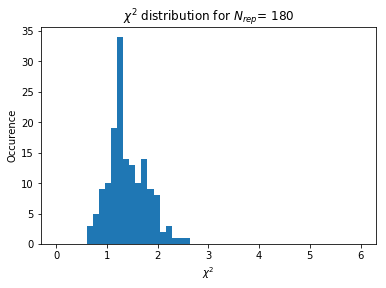

In [242]:
plt.hist(chi_data['Best chi2 value'], bins=50, range=[0, 6])
plt.title('$\chi^2$ distribution for $N_{rep}$= %(s)s' % {"s": len(chi2_array)})
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/histogram.png')
plt.show()

## Post-selection criteria

In [243]:
good_files = []
count = 0
for i,j in enumerate(chi2_array):
    selection_min = 1.2
    if j < selection_min:
        good_files.append('Keep') 
        count +=1 
    else:
        good_files.append('Discard')

print("The number of files that survived the selection is", count)

## Load extrapolation data

For each replica, the prediction should be taken separately:\
     $substracted\_spectrum_k = original\_spectrum - ZLP_k$

In [244]:
all_files_ex = glob.glob(path_1 + round_no + path_pred)
all_files_ex_sort = np.sort(all_files_ex)
use_files = []

## Use original ZLP data to substract:
original = ZLP_data[(ZLP_data['x1'] >= -.3) & (ZLP_data['x1'] <= 3)]

for i,j in enumerate(good_files):
    if j == 'Keep':
        file = all_files_ex_sort[i]
        use_files.append(file)
        

In [245]:
nbins = 660        
li = []
diff = []
count = 0

for filename in use_files:
    df = pd.read_csv(filename, delimiter=",", header=None, usecols=[0,1], names=['x', 'prediction'])
    df['k'] = count
    li.append(df)
    count += 1
    
extrapolation = pd.concat(li, axis=0, ignore_index=True)

lo = []

for k in range(count): 
    exp_k = extrapolation[extrapolation['k'] == k ]
    
    mean_k, var_k, count = binned_statistics(exp_k['x'], exp_k['prediction'], nbins)
    
    replica_file = pd.DataFrame({"k": k, "x1": original['x1'], "data log(y1)": original['log(y1)'], \
                                "prediction log(y1)": mean_k, \
                                "data y1": original['y1'], "prediction y": np.exp(mean_k), \
                                "difference": (original['y1'] - np.exp(mean_k))})
    lo.append(replica_file)
    
total_replicas = pd.concat(lo, axis=0, ignore_index = True, sort=False)

In [246]:
#total_replicas['data y2'], total_replicas['data y3'], total_replicas['data y2'], total_replicas['data y2']

total_replicas.head()

,k,x1,data log(y1),prediction log(y1),data y1,prediction y,difference
0,0,-0.295,10.839765,10.879148,51009.4,53058.391500,-2048.991500
1,0,-0.290,10.895969,10.933487,53958.4,56021.259597,-2062.859597
2,0,-0.285,10.954636,10.986797,57218.7,59088.803380,-1870.103380
3,0,-0.280,11.014822,11.040798,60768.2,62367.372021,-1599.172021
4,0,-0.275,11.070325,11.095464,64236.4,65871.709461,-1635.309461


In [247]:
mean_replicas_abs, var_replicas_abs, count_replicas_abs = \
binned_statistics(total_replicas['x1'], total_replicas['difference'], 400)

### Individual replicas

For each replica $k$, the NN gives a prediction on the ZLP: $ZLP_k$. The substracted spectrum at each iteration is then $Substraction_k = original\_spectrum - ZLP_k$.  

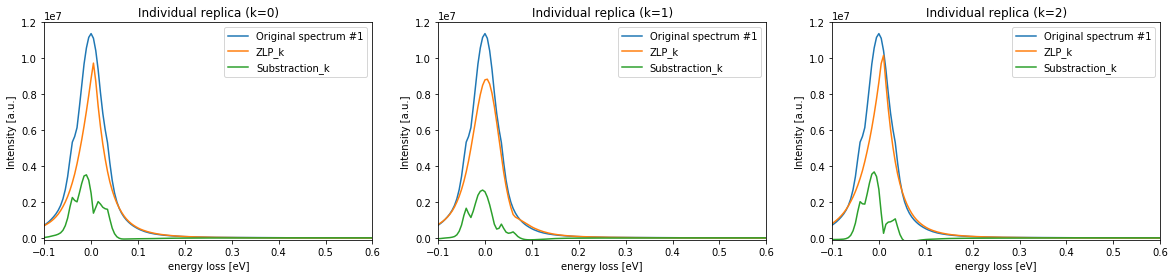

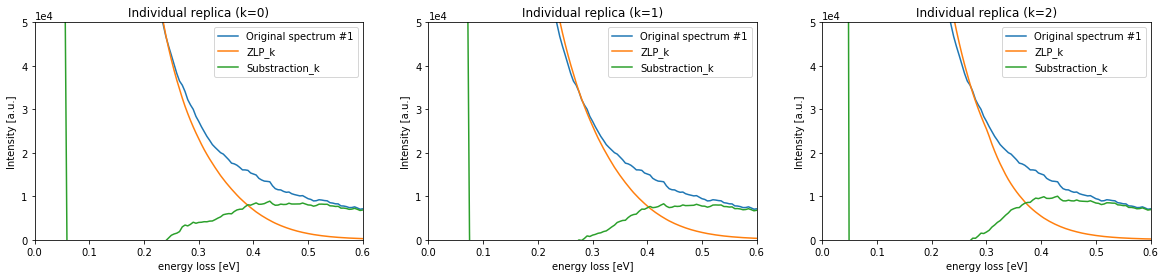

In [248]:
fig, axes = plt.subplots(1,3, figsize=(20,4), facecolor='w', edgecolor='k')
axes = axes.ravel()

for ax, k in zip(axes.flatten(), range(3)):
    exp_k = total_replicas[total_replicas["k"]==k]
    ax.plot(exp_k['x1'], exp_k['data y1'], label='Original spectrum #1')
    ax.plot(exp_k['x1'], exp_k['prediction y'], label='ZLP_k')
    ax.plot(exp_k['x1'], exp_k['difference'], label='Substraction_k')
    ax.set(xlim=[-.1,.6], ylim=[-1e5, 1.2e7], xlabel='energy loss [eV]', ylabel='Intensity [a.u.]', title='Individual replica (k=%(k)s)' % {"k": k})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.legend()
plt.savefig('Data/Results/Example_individual_replicas.png')

fig, axes = plt.subplots(1,3, figsize=(20,4), facecolor='w', edgecolor='k')
axes = axes.ravel()

for ax, k in zip(axes.flatten(), range(3)):
    exp_k = total_replicas[total_replicas["k"]==k]
    ax.plot(exp_k['x1'], exp_k['data y1'], label='Original spectrum #1')
    ax.plot(exp_k['x1'], exp_k['prediction y'], label='ZLP_k')
    ax.plot(exp_k['x1'], exp_k['difference'], label='Substraction_k')
    ax.set(xlim=[0,.6], ylim=[0, 5e4], xlabel='energy loss [eV]', ylabel='Intensity [a.u.]', title='Individual replica (k=%(k)s)' % {"k": k})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.legend()
plt.savefig('Data/Results/Example_individual_replicas(rescale).png')




In [249]:
nbins=600

mean_replicas_dif, var_replicas_dif, count_replicas_dif = \
binned_statistics(total_replicas['x1'], -(total_replicas['prediction y'] - total_replicas['data y1']), nbins)

mean_replicas_pred, var_replicas_pred, count_replicas_pred = \
binned_statistics(total_replicas['x1'], total_replicas['prediction y'], nbins)

### Average over all replicas

In order to obtain predictions on the substracted spectra, one has to average over all the replicas. This yields the mean and variance of the substractions, plotted in green below. 

Predicted ZLP mean = $1 / N_{rep} \cdot \sum_k ZLP_k $ \
\
Mean substraction = $1 / N_{rep} \cdot \sum_k (spectrum - ZLP_k )$ 


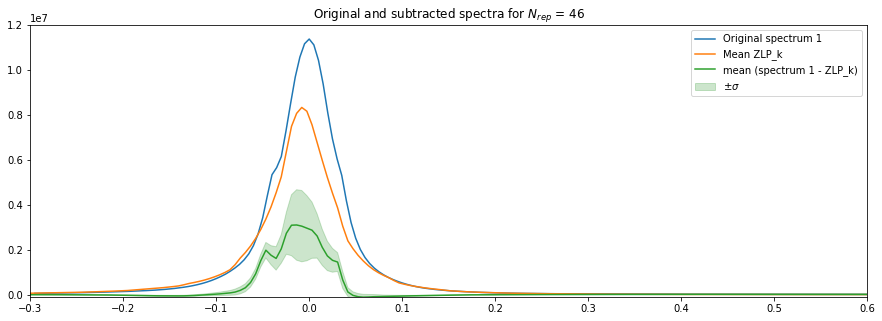

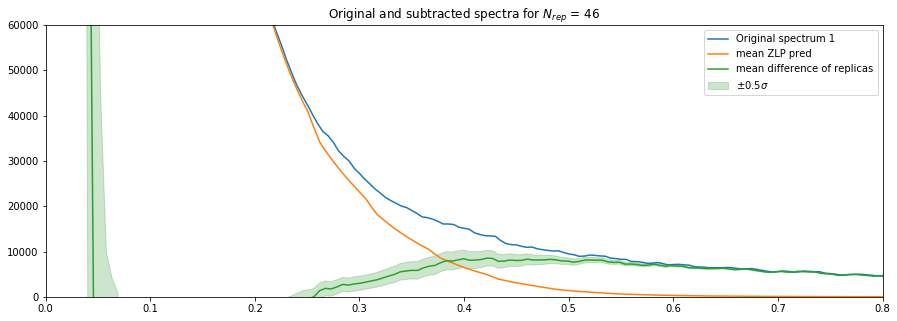

In [250]:
plt.figure(figsize=(15,5))
plt.plot(original['x1'], original['y1'], label='Original spectrum 1')
#plt.plot(original['x1'], original['y2'], color='lightblue', label='Original spectrum 2')
#plt.plot(original['x1'], original['y3'], color='lightblue', label='Original spectrum 3')
#plt.plot(original['x1'], original['y4'], color='lightblue', label='Original spectrum 4')
#plt.plot(original['x1'], original['y5'], color='lightblue', label='Original spectrum 5')
#plt.plot(original['x1'], original['y6'], color='lightblue', label='Original spectrum 6')
#plt.plot(original['x1'], original['y7'], color='lightblue', label='Original spectrum 7')

plt.plot(np.linspace(-.3, 3, nbins), mean_replicas_pred, label='Mean ZLP_k')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas_dif, label='mean (spectrum 1 - ZLP_k)')
plt.fill_between(np.linspace(-.3, 3, nbins), mean_replicas_dif + var_replicas_dif, \
                 mean_replicas_dif - var_replicas_dif, color='green',alpha=.2, label='$\pm \sigma$')
plt.title("Original and subtracted spectra for $N_{rep}$ = %(s)s" %{"s": len(use_files)})
plt.savefig('Data/Results/Subtracted_spectra.png')
plt.xlim([-.3,.6])
plt.ylim([-1e5, 1.2e7])
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(original['x1'], original['y1'], label='Original spectrum 1')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas_pred, label='mean ZLP pred')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas_dif, label='mean difference of replicas')
plt.fill_between(np.linspace(-.3, 3, nbins), mean_replicas_dif + var_replicas_dif, \
                 mean_replicas_dif - var_replicas_dif, color='green',alpha=.2, label='$\pm 0.5\sigma$')
plt.title("Original and subtracted spectra for $N_{rep}$ = %(s)s" %{"s": len(use_files)})

plt.xlim([0,.8])
plt.ylim([0, 6e4])
plt.savefig('Data/Results/Subtracted_spectra(rescale).png')
plt.legend()
plt.show()

## Report

Create a standardized report file with the main outcomes

In [251]:
import sys
import base64
from prettytable import PrettyTable
pt = PrettyTable

nummer = 1

reportname = r'Reports/%(date)s_%(i)s.html' % {"date": d_string, "i": round_no }
sys.stdout = open(reportname,'w')

print((d_string )+ 'round' + str( round_no ) + '<br />')
print('Subtraction of original spectrum 1 <br /><br />')

list1 = ['Training window:', 'Pseudo data added in range:']
list2 = [str([-.3, max(training_data['x'][(training_data['x']< .5)])]) +' eV', \
         str([min(training_data['x'][(training_data['x']> .5)]), max(training_data['x'][(training_data['x']>.5)])])]
for x in range(0,2):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 


list1 = ['Total no. of replicas:', 'Criterium Chi2:', 'Used no. of replicas:']
list2 = [len(all_files), selection_min, len(use_files)]

for x in range(0,3):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 

In [252]:
plot1 = r'Data/Results/Example_individual_replicas.png'
plot2 = r'Data/Results/Example_individual_replicas(rescale).png'

plot3 = r'Data/Results/histogram.png'
plot4 = r'Data/Results/Subtracted_spectra.png'
plot5 = r'Data/Results/Subtracted_spectra(rescale).png'

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
data_uri5 = base64.b64encode(open(plot5, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)
img_tag5 = '<img src="data:image/png;base64,{0}">'.format(data_uri5)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)
print(img_tag5)